In [1]:
import os, shutil, pickle
from Bio import SeqIO
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Model, Sequential
from keras.models import Sequential
from keras.layers import Dense, Dropout, MaxPooling1D, Flatten, Conv1D, LSTM, CuDNNLSTM, Bidirectional
from keras.optimizers import RMSprop, Adam
from keras.initializers import glorot_normal # also called Xavier Initialization

Using TensorFlow backend.


Randomly generate training data  
`train_x` has shape: (# of training data, max length of sequence, 4),
where the maximal length of sequence by default is 1000 and 4 reflects the one-hot encoding of one nucleotide(A, T, G, or C).

In [2]:
input_folder_path = "../../../temp/samples/"
output_folder_path = "../../../temp/buffers/"

# sample data from:
data_dir = "/home/ubuntu/group_volume/team_neural_network/data/input/3.24_species_only"

len(os.listdir(data_dir)) # total number of regions

3544

In [3]:
# all_data_lst = np.array(os.listdir(data_dir))
# n = len(all_data_lst)
# num_samples = 209

# np.random.seed(189)
# sample_indices = np.random.choice(np.arange(n), num_samples, replace = False)
# sample_files = all_data_lst[sample_indices]

# sample_files_list = []
# for file in sample_files:
#     sample_files_list.append(file)
#     shutil.copy(os.path.join(data_dir, file),
#                         input_folder_path)

In [4]:
# # Use the following dictionary to perform the transformation
# base_pairs = {'A': [1, 0, 0, 0], 
#               'C': [0, 1, 0, 0],
#               'G': [0, 0, 1, 0],
#               'T': [0, 0, 0, 1],
#               'a': [1, 0, 0, 0],
#               'c': [0, 1, 0, 0],
#               'g': [0, 0, 1, 0],
#               't': [0, 0, 0, 1],
#               'n': [0, 0, 0, 0],
#               'N': [0, 0, 0, 0]}

# file_num_limit = 10000    # The maximum number of files to be decoded
# file_count = 0

# # Iterate through every file
# all_regions = []
# for file in os.listdir(input_folder_path):
#     # When the number of file decoded has reached the limit, stop
#     if file_count < file_num_limit:
#         data = list(SeqIO.parse(input_folder_path + file,"fasta"))
#         for n in range(0, len(data)):
#             # Extract the header information
#             header = data[n].description.split('|')
#             descr = data[n].description
#             regionID = header[0]
#             expressed = header[1]
#             speciesID = header[2]
#             strand = header[3]
#             # Complement all sequences in the negative DNA strand
# #             if strand == '-':
# #                 # Using the syntax [e for e in base_pairs[n]] to create a new pointer for each position
# #                 one_hot.append([descr, expressed, speciesID, [[e for e in base_pairs[n]] for n in data[n].seq.complement()]])
# #             else:
#             all_regions.append([descr, expressed, speciesID, [[e for e in base_pairs[n]] for n in data[n].seq]])
#         file_count += 1
        
# output_name = 'all_regions.data'
# with open(output_folder_path + output_name, mode="wb") as output:
#     print("save to {}".format(os.path.join(output_folder_path, output_name)))
#     pickle.dump(all_regions, output)

### Load sampled data from a buffer

In [5]:
# output_name = 'all_regions.data'
# with open(os.path.join(output_folder_path, output_name), 'rb') as file:
#     all_regions = pickle.load(file)

In [4]:
# def curtail(lst, read_len):
#     if len(lst) > read_len:
#         lst = lst[:read_len]
#     else:
#         for i in range(read_len - len(lst)):
#             lst.append([0, 0, 0, 0])
#     return lst

In [7]:
# max_len = 1000

# train_x, train_y = [], []
# for region in all_regions:
#     y, x = int(region[1]), region[3]
#     x = curtail(x, max_len)
#     x = np.array(x).flatten()
#     x = x.reshape((1000, 4))
#     train_x.append(x)
#     train_y.append(y)

# train_x, train_y = np.array(train_x), np.array(train_y)

# train_x.shape, train_y.shape

((5016, 1000, 4), (5016,))

In [8]:
# with open(output_folder_path + 'train_x.data', mode="wb") as output:
#     print("save to {}".format(os.path.join(output_folder_path, 'train_x.data')))
#     pickle.dump(train_x, output)

# with open(output_folder_path + 'train_y.data', mode="wb") as output:
#     print("save to {}".format(os.path.join(output_folder_path, 'train_y.data')))
#     pickle.dump(train_y, output)

save to ../../../temp/buffers/train_x.data
save to ../../../temp/buffers/train_y.data


In [6]:
output_name = 'train_x.data'
with open(os.path.join(output_folder_path, output_name), 'rb') as file:
    train_x = pickle.load(file)

output_name = 'train_y.data'
with open(os.path.join(output_folder_path, output_name), 'rb') as file:
    train_y = pickle.load(file)

train_x.shape, train_y.shape

((5016, 1000, 4), (5016,))

Sanity check: overfit this small random dataset.

In [7]:
model = Sequential()
model.add(Conv1D(filters = 50, 
                 kernel_size = 26, 
                 padding = 'valid',
                 data_format = 'channels_last',
                 activation = 'relu'))
model.add(MaxPooling1D(pool_size = 10, strides = 10))
model.add(Dropout(0.7)) # 0.2
model.add(Bidirectional(LSTM(10), input_shape=(1000, 50)))
model.add(Dropout(0.6)) # 0.5
#model.add(Dense(100, activation = 'relu'))
init = glorot_normal(seed = 42)
model.add(Dense(20, activation = 'relu', kernel_initializer=init))
model.add(Dense(1, activation='sigmoid'))
opt = RMSprop(lr=0.0001, rho=0.9, epsilon=None, decay=0.0)
#opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['acc'])
history = model.fit(train_x, train_y, epochs=50, batch_size=100, validation_split=0.2)

Train on 4012 samples, validate on 1004 samples
Epoch 1/50
4012/4012 [==============================] - 18s 4ms/step - loss: 0.6879 - acc: 0.5601 - val_loss: 0.6920 - val_acc: 0.5149
Epoch 9/50
4012/4012 [==============================] - 18s 4ms/step - loss: 0.6885 - acc: 0.5474 - val_loss: 0.6915 - val_acc: 0.5309
Epoch 10/50
4012/4012 [==============================] - 18s 4ms/step - loss: 0.6861 - acc: 0.5591 - val_loss: 0.6916 - val_acc: 0.5239
Epoch 11/50
4012/4012 [==============================] - 17s 4ms/step - loss: 0.6868 - acc: 0.5518 - val_loss: 0.6895 - val_acc: 0.5737
Epoch 12/50
4012/4012 [==============================] - 17s 4ms/step - loss: 0.6857 - acc: 0.5523 - val_loss: 0.6946 - val_acc: 0.4622
Epoch 13/50
4012/4012 [==============================] - 17s 4ms/step - loss: 0.6842 - acc: 0.5563 - val_loss: 0.6963 - val_acc: 0.4382
Epoch 14/50
4012/4012 [==============================] - 18s 4ms/step - loss: 0.6854 - acc: 0.5491 - val_loss: 0.6856 - val_acc: 0.6295
Ep

In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 975, 50)           5250      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 97, 50)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 97, 50)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 20)                4880      
_________________________________________________________________
dropout_2 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 21        
Total para

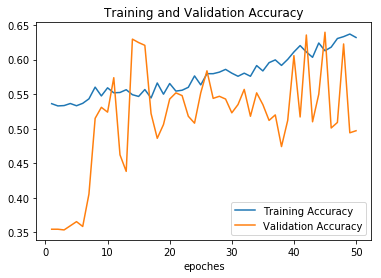

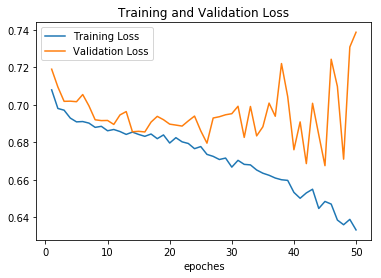

In [9]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, '-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('epoches')
plt.legend()

plt.figure()

plt.plot(epochs, loss, '-', label='Training Loss')
plt.plot(epochs, val_loss, '-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('epoches')
plt.legend()

plt.show()

In [61]:
i = 4
model.predict(train_x[i].reshape(1, -1, 4)), model.predict_classes(train_x[i].reshape(1, -1, 4))

(array([[0.53303534]], dtype=float32), array([[1]], dtype=int32))

In [62]:
conv_weights = model.layers[0].get_weights()

In [63]:
# weights
conv_weights[0].shape

(26, 4, 50)

In [64]:
# bias
conv_weights[1].shape

(50,)

In [65]:
model.layers[0].output

<tf.Tensor 'conv1d_2/Relu:0' shape=(?, 975, 50) dtype=float32>